<a href="https://colab.research.google.com/github/amitmakashir/Deep-learning/blob/master/part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import math

import warnings
warnings.filterwarnings("ignore") 

In [0]:
# Training data

# S is the clean file
s, sr = librosa.load('train_clean_male.wav', sr=None)
S = librosa.stft(s, n_fft=1024, hop_length=512)

# X is the dirty file
sn, sr = librosa.load('train_dirty_male.wav', sr=None)
X = librosa.stft(sn, n_fft=1024, hop_length=512)

# X.shape => (513, 2459)
X_mod = np.abs(X.T) # S_mod.shape => (2459, 513)

# S.shape => (513, 2459)
S_mod = np.abs(S.T) # S_mod.shape => (2459, 513)

no_of_features = X_mod.shape[1]
no_of_training_samples = X_mod.shape[0]

sr

16000

In [0]:
# Testing data

xt1, sr = librosa.load('test_x_01.wav', sr=None)
X_test1 = librosa.stft(xt1, n_fft=1024, hop_length=512)
xt2, sr = librosa.load('test_x_02.wav', sr=None)
X_test2 = librosa.stft(xt2, n_fft=1024, hop_length=512)

X_test1 = np.transpose(X_test1)
X_test1_mod = np.abs(X_test1) # X_test1_mod.shape => (142,513)

X_test2 = np.transpose(X_test2)
X_test2_mod = np.abs(X_test2) # X_test2_mod.shape => (380, 513)

print(X_test2_mod.shape)

(380, 513)


In [0]:
class miniBatch():
    def __init__(self,x,y,batch_size,random=True):
      self.x = x
      self.y = y
      
      if random:
        self.randomizeInputs()
        
      self.rows = len(x)
      self.batch_size = batch_size
      self.curr_index = 0
      
      # Total number of iterations
      self.iters = math.ceil(self.rows/self.batch_size)
      pass
    
    def randomizeInputs(self):
      assert len(self.x) == len(self.y)
      
      p = np.random.RandomState(seed=107).permutation(len(self.x))
      self.x = self.x[p]
      self.y = self.y[p]
      return True

    
    def nextBatch(self):
      '''
      If the last batch is not of the batch size, give all the remaining elements
      '''
      
      if self.curr_index+self.batch_size >= self.rows:
        batch_x = self.x[self.curr_index:]
        batch_y = self.y[self.curr_index:]
      else:
        batch_x = self.x[self.curr_index:self.curr_index+self.batch_size]
        batch_y = self.y[self.curr_index:self.curr_index+self.batch_size]
      
      self.curr_index = self.curr_index+self.batch_size
      return batch_x,batch_y
    
        
def crossValSet(x,y,size):
  '''
  Size will be in percent
  Remove "size"% of data from the last as keep it for CV  
  '''
  no_of_elements = math.ceil(len(x)*(size/100))
  
  train_x = x[:-no_of_elements]
  train_y = y[:-no_of_elements]
  
  cv_x = x[-no_of_elements:]
  cv_y = y[-no_of_elements:]    
  return train_x,train_y,cv_x,cv_y



def transform_input(x):
  '''
  The input to this function is something like this:
  x.shape => [batch_size,1,1,513]
  
  Take the first 20 frames, and convert it a image or just combine them
  Now this is your data point.
  x_new.shape => [batch_size,1,20,513]
  '''
  rows = x.shape[0]
  columns = x.shape[1]
  grid_size = 20
  no_of_channels = 1
  
  new_rows = rows - grid_size + 1 
  x_new = np.array([])
  
  x_new = [x[row_index:row_index+grid_size] for row_index in range(new_rows)]
  x_new = np.array(x_new)
  
  x_new = x_new.reshape(new_rows,grid_size,columns,no_of_channels)
  return x_new

In [0]:
# Hyperparameters
epochs = 350
learning_rate = 0.0002
batch_size = 32
cv_size = 10

In [0]:
transformed_X = transform_input(X_mod)

# Drop the first 19 examples because of the transformation
train_x,train_y,cv_x,cv_y = crossValSet(transformed_X,S_mod[19:],cv_size) 

In [0]:
## Create placeholders for input X and labels y
x_input = tf.placeholder(tf.float32, [None,20,513,1])
y_true = tf.placeholder(tf.float32, [None,513])


# He initialization
he_initializer = tf.contrib.layers.variance_scaling_initializer()
    
# Architecture of Network
layer1 = { "type":"conv2d",
            "filters":16,
            "kernel_size":[4,8],
         }

layer2 = { "type":"maxpool",
            "pool_size":2,
            "padding":'valid'
         }


layer3 = { "type":"conv2d",
            "filters":32,
            "kernel_size":2,
         }


layer4 = { "type":"maxpool",
            "pool_size":2,
            "padding":'valid'
         }


layers = [layer1,layer2,layer3,layer4]





def construct_network(input_x,layers):
    '''
    Consruct a network depending on the configuration
    '''
    constructed_network = []
    
    last_conv_filter = 0
    no_of_maxpool = 0
    
    # He initialization
    he_initializer = tf.contrib.layers.variance_scaling_initializer()
    
    for layer in layers:
      
      if len(constructed_network) == 0: # This is the First layer
        this_input = input_x
      else:
        this_input = constructed_network[-1]
   
      
      if layer["type"] == "conv2d":
        current_layer = tf.layers.conv2d( 
                          inputs = this_input,
                         filters = layer["filters"],
                         kernel_size = layer["kernel_size"],
                         strides = 1,
                         padding = "SAME",
                         kernel_initializer = he_initializer,
                         activation = tf.nn.relu
                        )
        
        last_conv_filter = layer["filters"]
        
      elif layer["type"] == "maxpool":
        current_layer = tf.layers.max_pooling2d(
                          inputs = this_input,
                          pool_size = layer["pool_size"],
                          strides = layer["pool_size"], # Same as pool size to not consider the same box twice
                          padding='valid'
                        )
        
        no_of_maxpool += 1
        
      # Push this layer to network
      constructed_network.append(current_layer)
      
    # Fully connected layer
    # Reshape this layer3 to by flattening this tensor's last 2 dim
    
    flat_dimensions = (513//(2*no_of_maxpool))*(20//(2*no_of_maxpool))*last_conv_filter 
    
    reshaped_layer = tf.reshape(
        constructed_network[-1],
        [-1,flat_dimensions],
        )
    
    second_last_layer = tf.layers.dense(
        inputs = reshaped_layer,
        units = 2048,
        activation = tf.nn.relu,
        use_bias = True,
        kernel_initializer = he_initializer,
        bias_initializer = tf.zeros_initializer(),
        kernel_regularizer = None,
        bias_regularizer = None,
        activity_regularizer = None,
        kernel_constraint = None
        )
    
    dropout_layer = tf.layers.dropout(second_last_layer,
                      rate=0.3
                     )
    
    last_layer = tf.layers.dense(
        inputs = dropout_layer,
        units = 513,
        activation = tf.nn.relu,
        use_bias = True,
        kernel_initializer = he_initializer,
        bias_initializer = tf.zeros_initializer(),
        kernel_regularizer = None,
        bias_regularizer = None,
        activity_regularizer = None,
        kernel_constraint = None
        )
    
    constructed_network.append(last_layer)

    return constructed_network



# ============== Main Program =========================


constructed_network = construct_network(x_input,layers)
y_pred = constructed_network[-1]

## Define the cost function to be optimized and the optimizer to be used  
cost = tf.losses.mean_squared_error(y_pred, y_true)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cost)

### Start the session
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()



# ====== Training the network ======  

cross_validation_errors = []

for e in range(epochs):
  # Create minibatches and train data on it
  mini_batch = miniBatch(train_x,train_y,batch_size)
  
  for iter in range(mini_batch.iters):
    batch_x,batch_y = mini_batch.nextBatch()
    sess.run(train_step, feed_dict={x_input: batch_x, y_true: batch_y})

  # After every epoch, check the CV error
  cross_validation_errors.append(sess.run(cost, feed_dict={x_input: cv_x, y_true: cv_y}))
  if e%10 == 0:
    print("Epoch:"+ str(e) + "\t CV Error:" + str(cross_validation_errors[-1]))
  
# ====== Training ends ======    

    
## Running a feedforward on the test samples
s_test_1 = sess.run(y_pred,feed_dict={x_input: transform_input(X_test1_mod)})
s_test_2 = sess.run(y_pred,feed_dict={x_input: transform_input(X_test2_mod)})

# for calculating SNR
y_train = sess.run(y_pred,feed_dict={x_input: transform_input(X_mod)})

sess.close()

In [0]:
# Convert the output of test sample 1 to wav file
output_1 = (X_test1[19:]/X_test1_mod[19:]) * s_test_1
output_istft_1 = librosa.istft(output_1.T, hop_length=512, win_length=1024)
librosa.output.write_wav('test_s_01_recons.wav',output_istft_1, sr)

In [0]:
# Convert the output of test sample 2 to wav file
output_2 = (X_test2[19:]/X_test2_mod[19:]) * s_test_2
output_istft_2 = librosa.istft(output_2.T, hop_length=512, win_length=1024)
librosa.output.write_wav('test_s_02_recons.wav', output_istft_2, sr)

In [0]:
# y_train is the output of network
# y_train only has 2440 rows, to match it to the input, we add 19 silent frames

silent_frame = np.random.random((19, 513))
silent_frame = silent_frame * 10**-5

training_ouput = np.concatenate((silent_frame, y_train), axis=0)

s_train_pred = (X.T/X_mod)*training_ouput
s_train = librosa.istft(s_train_pred.T, hop_length=512, win_length=1024)   
len_s = s_train.shape[0]

def calcSNR(s_pred_td,s_true_td):
      if s_pred_td.shape[0] != s_true_td.shape[0]:
        min_length = min(s_pred_td.shape[0],s_true_td.shape[0])
        s_pred_td = s_pred_td[:min_length]
        s_true_td = s_true_td[:min_length]
      
      signal = np.sum(np.square(s_true_td))
      noise = np.sum(np.square(s_true_td - s_pred_td))
      
      snr = 10 * np.log10(signal/noise)
      
      return snr
    
train_snr = calcSNR(s_train,s)
print("SNR for the training audio file: " + str(round(train_snr,3)))

SNR for the training audio file: 14.441


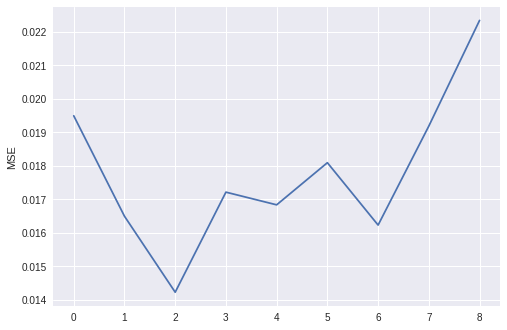

Mean squared error for the last iteration: 0.016


In [0]:
def error_plot(errors,no_of_points):
  step = len(errors) // no_of_points
  
  err = [errors[i] for i in range(step,len(errors),step)]
  
  plt.plot(err)
  plt.ylabel("MSE")
  plt.show()
  
  return errors[-1]

error_plot(cross_validation_errors,10)
print("Mean squared error for the last iteration: " + str(round(cross_validation_errors[-1],3)))  